<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Case-2" data-toc-modified-id="Case-2-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Case 2</a></span></li><li><span><a href="#Background" data-toc-modified-id="Background-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Background</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Models-and-training" data-toc-modified-id="Models-and-training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Models and training</a></span></li><li><span><a href="#Results-and-Discussion" data-toc-modified-id="Results-and-Discussion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Results and Discussion</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

# Case 2
Ville Kajander, Topias Paljakka and Ville Tuomi - Team 8<br>
Last edited: 28.02.2020<br>
Neural Networks for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

# Background
The aim of this notebook is to study x-ray images of lungs using convolutional neural network.

# Data
The data contained images of healthy lungs and lungs with pneumonia. The data was downloaded from [here](https://data.mendeley.com/datasets/rscbjbr9sj/2). The size of the data was 1.16 GB and it was divided into training set and testing set. The training set had 1349 images of healthy lungs and 3883 images of lungs with pneumonia. The testing set had 234 images of healthy lungs and 390 images of lungs with pneumonia.

In [1]:
%pylab inline
import os, shutil

Populating the interactive namespace from numpy and matplotlib


Hyper parameters:

In [2]:
proportions = (0.6, 0.2, 0.2) # Proportions between train, validation and test set
batch_size = 16
epochs = 5
target_size = (150,150)

workers = 4 # Maximum number of processes to spin up when using process-based threading

Remove existing directories and make new directories.

In [3]:
%%time
train_dir = './train'
valid_dir = './validation'
test_dir = './test'
all_dirs = [train_dir, valid_dir, test_dir]

for d in all_dirs:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.mkdir(d)
    os.mkdir(os.path.join(d,'NORMAL'))
    os.mkdir(os.path.join(d,'PNEUMONIA'))
print(os.listdir(train_dir))

['NORMAL', 'PNEUMONIA']
Wall time: 1.58 s


List all normal and pneumonia image paths in original train and test data.

In [4]:
%%time

orig_dir = 'chest_xray/train'
orig_dir2 = 'chest_xray/test'

normal_images = [os.path.join(orig_dir, 'NORMAL', x) for x in os.listdir(os.path.join(orig_dir, 'NORMAL')) if x.endswith('.jpeg')]
normal_images += [os.path.join(orig_dir2, 'NORMAL', x) for x in os.listdir(os.path.join(orig_dir2, 'NORMAL')) if x.endswith('.jpeg')]
pneumonia_images = [os.path.join(orig_dir, 'PNEUMONIA', x) for x in os.listdir(os.path.join(orig_dir, 'PNEUMONIA')) if x.endswith('.jpeg')]
pneumonia_images += [os.path.join(orig_dir2, 'PNEUMONIA', x) for x in os.listdir(os.path.join(orig_dir2, 'PNEUMONIA')) if x.endswith('.jpeg')]


print('Num of normal images:', len(normal_images))
print('Num of pneumonia images:', len(pneumonia_images))

Num of normal images: 1583
Num of pneumonia images: 4273
Wall time: 39.9 ms


Randomize the order of the images.

In [5]:
%%time
random.seed(1)
random.shuffle(normal_images)
random.shuffle(pneumonia_images)

Wall time: 1 ms


Copy the images from original directories to new ones and split them into train, validation and test folders.

In [6]:
%%time

# Splits given list into multiple lists with given proportions
def data_split(proportions, data):
    for x in np.split(data, np.cumsum(np.rint(np.dot(proportions, len(data))).astype(int))):
         yield x.tolist()

for directory, normals, pneumonias in zip(all_dirs, data_split(proportions, normal_images), 
                                                    data_split(proportions, pneumonia_images)):
    for file in normals + pneumonias:
        shutil.copyfile(file, os.path.join(directory, file.split('\\', 1)[1]))

Wall time: 8.64 s


Create three image data generators one for each data set.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dg = ImageDataGenerator(rescale=1./255)

class_mode = 'binary'

train_generator = dg.flow_from_directory(
    train_dir, 
    target_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=False)

dev_generator = dg.flow_from_directory(
    valid_dir, 
    target_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=False)

test_generator = dg.flow_from_directory(
    test_dir, 
    target_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=False)

Found 3514 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.


Sampling a single image from one of the generators to test it.

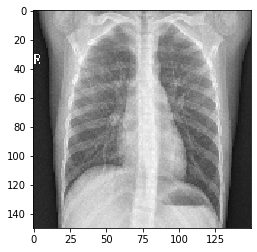

(150, 150, 3)

In [8]:
data_batch = train_generator[0][0]
imshow(data_batch[0])
show()
data_batch[0].shape

# Models and training
Build process of our best model.

In [34]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model1 = Sequential(name='Beast')
model1.add(Conv2D(64, (3,3), input_shape=data_batch[0].shape))
model1.add(Conv2D(64, (3,3)))
model1.add(MaxPool2D((2,2)))
model1.add(Flatten())
model1.add(Dense(1, activation='sigmoid'))
model1.summary() 

Model: "Beast"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 146, 146, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 341056)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 341057    
Total params: 379,777
Trainable params: 379,777
Non-trainable params: 0
_________________________________________________________________


Two of our previously build models are loaded from memory.

In [36]:
model2 = load_model('model_001.h5')
model2.summary()

print()

model3 = load_model('model_002.h5')
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 73, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10368)             0

Compile the model.

In [10]:
from tensorflow.keras.metrics import SensitivityAtSpecificity

model1.compile(loss='binary_crossentropy', metrics=[SensitivityAtSpecificity(0.9)])

Calculate the maximum steps per epoch and validation steps given sample size and batch size.

In [11]:
steps_per_epoch = int(train_generator.samples / batch_size)
validation_steps = int(dev_generator.samples / batch_size)

print(steps_per_epoch, validation_steps)

219 73


Train the model.

In [12]:
%%time
history = model1.fit(train_generator,
                      workers=workers,
                      steps_per_epoch=steps_per_epoch,
                      verbose=1,
                      epochs=epochs,
                      validation_data=dev_generator,
                      validation_steps=validation_steps)

Train for 219 steps, validate for 73 steps
Epoch 1/5
219/219 [==============================] - 314s 1s/step - loss: 5.1163 - sensitivity_at_specificity: 0.0000e+00 - val_loss: 0.5448 - val_sensitivity_at_specificity: 0.8801
Epoch 2/5
219/219 [==============================] - 316s 1s/step - loss: 1.1254 - sensitivity_at_specificity: 0.6685 - val_loss: 0.2480 - val_sensitivity_at_specificity: 0.9377
Epoch 3/5
219/219 [==============================] - 312s 1s/step - loss: 0.7919 - sensitivity_at_specificity: 0.7410 - val_loss: 0.2255 - val_sensitivity_at_specificity: 0.9530
Epoch 4/5
219/219 [==============================] - 310s 1s/step - loss: 0.6419 - sensitivity_at_specificity: 0.8214 - val_loss: 0.4668 - val_sensitivity_at_specificity: 0.9565
Epoch 5/5
219/219 [==============================] - 310s 1s/step - loss: 0.5839 - sensitivity_at_specificity: 0.8366 - val_loss: 0.8951 - val_sensitivity_at_specificity: 0.0000e+00
Wall time: 27min 11s


# Results and Discussion

Look up the metric values names available.

In [13]:
history.history.keys()

dict_keys(['loss', 'sensitivity_at_specificity', 'val_loss', 'val_sensitivity_at_specificity'])

Assign helper variables.

In [14]:
sas = history.history['sensitivity_at_specificity']
val_sas = history.history['val_sensitivity_at_specificity']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(sas))

Plot the sensitivity at specificity and loss metrics for the model1.

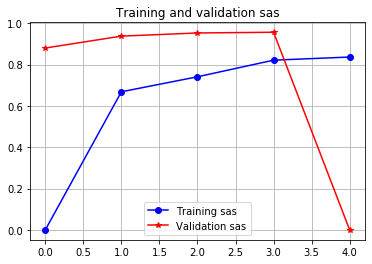

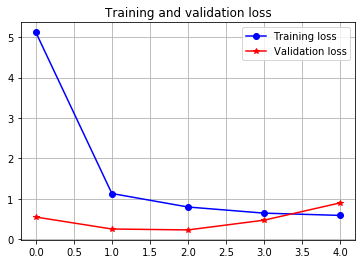

In [15]:
plot(epochs_range,sas,'bo-',label='Training sas')
plot(epochs_range,val_sas,'r*-',label='Validation sas')
title('Training and validation sas')
grid()
legend()

figure()
plot(epochs_range,loss,'bo-',label='Training loss')
plot(epochs_range,val_loss,'r*-',label='Validation loss')
title('Training and validation loss')
grid()
legend()

show()

Save the model as new into './models' -folder.

In [16]:
model_file_dir = './models'
if not os.path.exists(model_file_dir):
    os.mkdir(model_file_dir)

count = len(os.listdir(model_file_dir)) + 1
print(count)

new_file_path = '%s/model_%03d_epochs_%d.h5' % (model_file_dir, count,  epochs)
print(new_file_path)

model1.save(new_file_path)

12
./models/model_012_epochs_5.h5


True values from test data.

In [17]:
labels = test_generator.classes

Values predicted by the model from the test data.

In [44]:
pred1 = model1.predict(test_generator, workers=workers)
pred2 = model2.predict(test_generator, workers=workers)
pred3 = model3.predict(test_generator, workers=workers)

In [89]:
preds = [x for x in zip([pred1, pred2, pred3], [model.name, model2.name, model3.name])]

Plot true and predicted values.

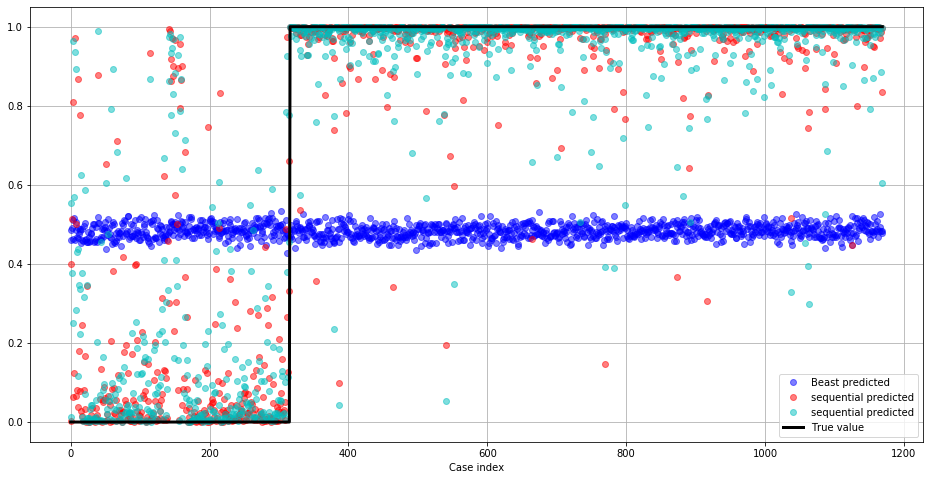

In [77]:
figure(figsize=(16,8))
plot(preds[0][0], 'bo', alpha=0.5, label=f'{preds[0][1]} predicted')
plot(preds[0][0], 'ro', alpha=0.5, label=f'{preds[0][1]} predicted')
plot(preds[0][0], 'co', alpha=0.5, label=f'{preds[0][1]} predicted')
plot(labels, '-', c='black', lw=3, label='True value')
legend()
xlabel('Case index')
grid()
show()

Confusion matrix.

In [83]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

print('Confusion matrices: ')
for pred, name in preds:
    print(confusion_matrix(labels, pred > 0.5).T)

Confusion matrices: 
[[240 699]
 [ 76 155]]
[[286   9]
 [ 30 845]]
[[276  10]
 [ 40 844]]


Classification report.

In [92]:
for pred, name in preds:
    print(f'\n{name}:')
    print(classification_report(labels, pred > 0.5, target_names=['Normal (0)','Pneumonia (1)']))


Beast:
               precision    recall  f1-score   support

   Normal (0)       0.26      0.76      0.38       316
Pneumonia (1)       0.67      0.18      0.29       854

     accuracy                           0.34      1170
    macro avg       0.46      0.47      0.33      1170
 weighted avg       0.56      0.34      0.31      1170


sequential:
               precision    recall  f1-score   support

   Normal (0)       0.97      0.91      0.94       316
Pneumonia (1)       0.97      0.99      0.98       854

     accuracy                           0.97      1170
    macro avg       0.97      0.95      0.96      1170
 weighted avg       0.97      0.97      0.97      1170


sequential:
               precision    recall  f1-score   support

   Normal (0)       0.97      0.87      0.92       316
Pneumonia (1)       0.95      0.99      0.97       854

     accuracy                           0.96      1170
    macro avg       0.96      0.93      0.94      1170
 weighted avg       0.9

ROC curve (Receiver Operating Characteristic)

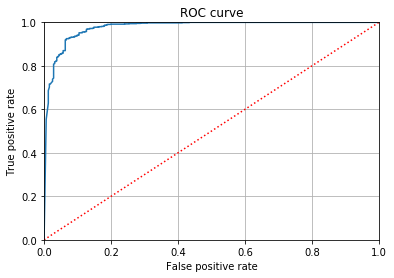

In [22]:
fpr, tpr, tresholds = roc_curve(labels, predicted, pos_label=1)

plot(fpr, tpr)
plot([0, 1], [0, 1], 'r:')
xlabel('False positive rate')
ylabel('True positive rate')
title('ROC curve')
xlim([0,1])
ylim([0,1])
grid()
show()

# Conclusions